# __Homework 2 - Instagram Profiles & Posts__

Libraries:

In [1]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os
import datatable as dt
from math import pi, floor, log10, ceil


SAMPLE_SIZE = 10000

%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***

## __Preprocessing__

We create a `Dataset` class that will help us manage the 3 datasets throughout the processing. As the datasets are very big, we settled to load only some columns for each question. This is managed by the 
```python
Dataset.col(columns:list) -> pd.DataFrame
``` 
method that will be used multiple times throughout the homework to selectively load only some columns from the csv files, using `datatable` library as it is more efficient in the usage of multiple cores, and loads way faster. Then the `datatable` object is casted to a common `pandas` DataFrame.

In [3]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def __types_file__(self):
        return 'types/' + self.name() +'.npy'
        
    def save_types(self):
        np.save(self.__types_file__(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.__types_file__()):
            self.types = np.load(self.__types_file__(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def col(self,columns:list, index=True,**dt_params)->pd.DataFrame:
        """Loads some columns of the dataframe out of the whole csv file
        
        :param columns: a list of the desired columns
        :type columns: list
        :param index: if True loads also the 'sid' column as the index
        :type index: bool
        :param **pd_params: any other params for pd.read_csv(...)
        :rtype: pd.DataFrame
        """
        col_list = columns
        if index==True:
            col_list.append('sid')
        d = dt.fread(self.file_name,
                           columns=set(col_list),
                           sep='\t',
                            **dt_params)
        if index == True:
            d.key = 'sid'
        elif index:
            d.key = index
        d = d.to_pandas().astype({k:v for k,v in self.types.items() if k in d.names})
        if 'cts' in col_list:
            d['cts'] = pd.to_datetime(d['cts'])
#             d = d.astype({'cts': 'datetime64'})
        return d

datasets = [
    Dataset(file='../input/instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='../input/instagram-dataset/instagram_locations.csv'), 
    Dataset(file='../input/instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

We inferred most of the types of the columns from the descriptions [here](https://www.kaggle.com/datasets/shmalex/instagram-dataset/versions/3), at least for what regard whether they are numeric, `boolean`, string type or something else.
We want to optimize the `dtype` of each column since in this way we'll save some precious memory space, and overall ease the computation.

For **numeric** and **string** dtypes:
- if they can assume only a small number of values we cast the to `categorical`, which is a special `dtype` that represents categorical data. This was applied to columns: 
    - 'post_type': [1,2,3]
    - 'cd' : country names (around 200 values)
    
For **numeric** dtypes:
- if they're integer we temporarily assign them to `Int64`, but further optimization will be performed later
- else they're assigned as `float`
    - 'lat' and 'lng' are assigned directly as `Float32` since the values they contain are in a fairly small range with not much precision needed

For **string** dtypes:
- if they represent dates they will be casted to `datetime64[ns,]` in the `Datetime.col()` method
    - 'cts'
- they are assigned as `pd.StringDtype(storage='pyarrow')` as we noted that this (experimental) dtype allows us to highly improve memory usage
    - this is appllied to the majority of columns

In [4]:
profiles.types = {
#     'sid' : 'Int64',
    'profile_id' : 'Int64',
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : 'Int64',
    'followers' : 'Int64',
    'n_posts' : 'Int64',
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'sid_profile' : 'Int64',
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : 'Int64',
    'location_id' : 'Int64',
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : 'Int64',
    'number_comments' : 'Int64'
}
locations.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'id' : 'Int64',
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [5]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    print(delimiter)
    for chunk in pd.read_csv(file_path, 
                             usecols=[column],
                             delimiter=delimiter,
                             chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

Since the `int` columns are the most used in the research questions, we try to _squeeze_ out each and every useful Byte. As such we perform a further optimization on their dtypes, trying to downcast their `int` dtype to the minimum.

    Int8 < Int16 < Int32 < Int64 
    
As such we wrote some functions that for each `Int64` column previously assigned, reads the values of that column and then returns the smallest possible `IntXX` dtype.

---
At the end we obtain a substantial reduction of memory usage, **saving around 60 to 70%** from the unoptimized version (note that we estimated this in a sample of the whole dataset)

In [6]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v == 'Int64']
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
    ds.save_types()

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%')

instagram_profiles  mean optimized memory usage per entry:  150 B vs  542 B  : 27.71%
instagram_locations mean optimized memory usage per entry:  272 B vs 1117 B  : 24.34%
instagram_posts     mean optimized memory usage per entry:  277 B vs  752 B  : 36.89%


In [7]:
for ds in datasets:
    print(ds.name())
    {print(f"\t{k:25}\t{v}") for k,v in ds.types.items() if pd.api.types.is_numeric_dtype(v)}

instagram_profiles
	profile_id               	UInt64
	following                	UInt32
	followers                	UInt32
	n_posts                  	UInt32
	is_business_account      	boolean
instagram_locations
	id                       	UInt64
	aj_exact_city_match      	boolean
	aj_exact_country_match   	boolean
	lat                      	Float32
	lng                      	Float32
instagram_posts
	sid_profile              	Int32
	profile_id               	UInt64
	location_id              	UInt64
	numbr_likes              	Int64
	number_comments          	UInt32


#### Profiles 
| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| profile_id | Instagrams ID | `int `|
| profile_name | profile name | `string` |
| firstname_lastname | firstname lastname | `string` |
| description | May contain '\n' | `string` |
| following | Number of following profile at the moment it was visited | `int` |
| followers | Number of followers at the moment it was visited | `int` |
| n_posts | Number of posts at the moment it was visited | `int` |
| url | Url in profile description | `string` |
| cts | Timestamp when the profile was visited | `datetime` |
| is_business_account | Boolean flag if that profile was makred by the owner as business account | `bool` |

#### Locations

| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| ID | Instagrams ID | `int` |
| Name | Locations Name | `string` |
| Street | Street Address, may contain '\n' | `string` |
| ZIP | Zip code | `string` |
| City | City Name | `string` |
| Region | Region | `string` |
| CD | Country Code | `string` |
| Phone | The phone in format as on the Instragram | `string` |
| aj_exact_city_match | The Instagrams Internal key | `bool` |
| aj_exact_country_match | The Instagrams Internal key | `bool` |
| blurb | Description of the place, may contain '\n' | `string` |
| dir_city_id | The Instagrams internal City ID | `string` |
| dir_city_name | city Name | `string` |
| dir_city_slug | City tag (sortof) | `string` |
| dir_country_id | Country ID | `categorical` |
| dir_country_name | country | `categorical` |
| lat | Latitude | `float` |
| lng | Longtitude | `float` |
| primary_alias_on_fb | Bool Flag | `bool` |
| slug | ??? | `string` |
| website | The URL to web site, may contain more then 1 URL, may contain '\n' | `string` |
| cts | Timestamp when the location was visited | `datetime` |

#### Posts
| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| sid_profile | Sequence ID of the profile from *Profiles* table, -1 if not in *Profiles* table | `int` |
| post_id | Instagrams ID | `string` |
| profile_id | Instagrams ID may be null | `int` |
| location_id | Instagrams ID | `int` |
| cts | Timestamp when the Post was created | `datetime` |
| post_type | 1 - Photo, 2 - Video, 3 - multy | `categorical` |
| description | May contain '\n' | `string` |
| number_likes | Number of Likes at the moment it was visited | `int` |
| number_comments | Number of comments at the moment it was visited | `int` |

***

### __1. [RQ1] After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our datasets? Please summarise its main characteristics with visual and tabular methods.__

***

***

### __2. [RQ2] Let's explore the dataset by finding simple insights regarding the profile and posts.__

***

#### $\bullet$ Plot the number of posts for each profile in descending order.

#### $\bullet$ What posts have the highest number of "likes"?

#### $\bullet$ What posts have the most and the least number of comments?

#### $\bullet$ How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

#### $\bullet$ How many posts include only photos? How many also have videos?

#### $\bullet$ What's the percentage of business accounts vs non- business? What can you interpret regarding that percentage?

***

### 3. __[RQ3] Now it's important to understand the most common times in which users publish their posts__

***

#### What is the most common time in which users publish their posts?

I can visualize the most common time by using a radar chart, we can observe that the peak hour for posting is at 19, and in general in the evening.

In [9]:
time = posts.col(['cts'], index=False, max_nrows=1000000)
time['hour'] = time['cts'].dt.hour

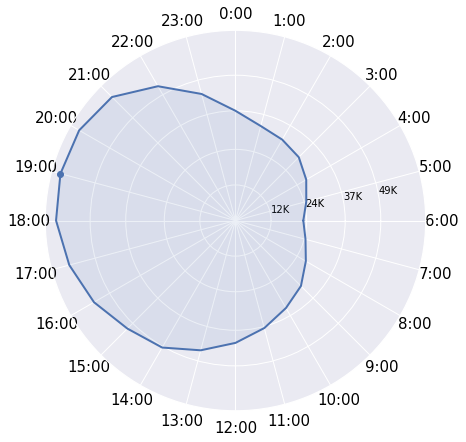

In [29]:
def cool_ticks(value, tick_number=None):
    '''based on https://stackoverflow.com/a/59973033/9419492'''
    num_thousands = 0 if abs(value) < 1000 else floor(log10(abs(value))/3)
    value = round(value / 1000**num_thousands)
    if value >= 1000:
        value /= 1000
        num_thousands += 1
    return f'{value:g}'+' KMGTPEZY'[num_thousands], value * 1000**num_thousands

def clock_graph(hours: pd.Series, labels:list=None):
    '''plots a Series in a Radar Chart.
        :hours: a pandas series where each row index will become an angle
    '''
    plt.figure(figsize=(7,7))

    # https://www.python-graph-gallery.com/390-basic-radar-chart
    N = len(hours)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    angles = angles[::-1]
    hours = pd.concat([
        hours.iloc[N//4:],
        hours.iloc[:N//4] ]) if N==24 else hours.sort_index(ascending=False)
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels
    labels = labels if labels is not None else hours.index.map(lambda h: f"{int(h)}:00")
    plt.xticks(angles[:-1], labels, color='black', size=15)

    # Draw ylabels
    ax.set_rlabel_position(10)
    M = hours.max()
    ticks = [cool_ticks(M*x/5) for x in range(1,5)]
    plt.yticks([v[1] for v in ticks], [t[0] for t in ticks], color="black", size=10)
    plt.ylim(0,M*21/20)
    
    # Plot data
    ax.plot(angles, [*hours, hours.iloc[0]], linewidth=2, linestyle='solid')
    hour_max = hours.index.get_loc(hours.idxmax()) if N!=24 else hours.idxmax()-N//4
    ax.plot(angles[hour_max],M, 'bo', label=f"Max: {M}")

    # Fill area
    ax.fill(angles[:-1], hours, 'b', alpha=0.1)

hours = time.hour.value_counts(sort=False).sort_index().to_frame()

clock_graph(hours.hour)

#### $\bullet$ Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

In [31]:
def inter(h,intervals:dict):
    for k,(m,M) in intervals.items():
        if (h >= m and h <= M) or (m>M and (h >= m or h <= M)):
            return k
    assert False, 'Interval not given: ' + str(h)
        
def plot_intervals(hours_count, inters=range(0,24,4), col_name='hour'):
    """A radarplot with the hours divided into intervals
    :hours_count: a dataframe where index is the hours
    :inters: a sorted list of hours breakpoints, with values between 1 and 24 
    :col_name: the column of which the values have to be plotted
    """
    assert min(inters)>0 and max(inters)<=24, 'Values must be included in 1..24'
    intervals = { f"[{inters[i-1]}:00,{inters[i]-1}:59)" : (inters[i-1],inters[i]-1) for i in range(len(inters)) }
    I = pd.CategoricalDtype(categories=intervals.keys() , ordered=True)
    hours_count['intervals'] = hours_count.index.to_series().apply(
        lambda h :inter(h, intervals)
    ).astype(I)
    clock_graph(hours_count.groupby(by='intervals').sum()[col_name], labels=I.categories)

#### $\bullet$ Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

| Initial time | Final time |
|---|---|
| 06:00:00 | 10:59:59 |
| 11:00:00 | 13:59:59 |
| 14:00:00 | 16:59:59 |
| 17:00:00 | 19:59:59 |
| 20:00:00 | 23:59:59 |
| 00:00:00 | 02:59:59 |
| 03:00:00 | 05:59:59 |

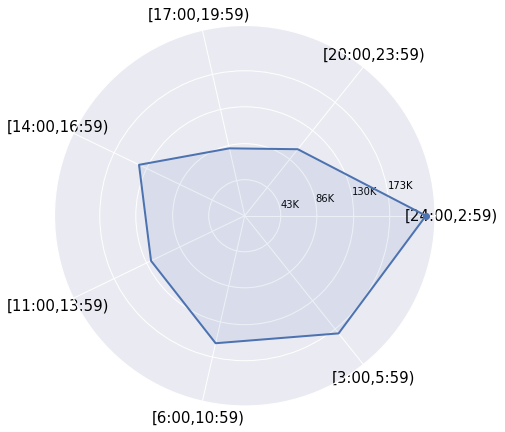

In [32]:
INTERVALS = [3,6,11,14,17,20,24]
plot_intervals(hours, INTERVALS)

In [ ]:
del time
del hours

***

### 4. __[RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.__

***

#### $\bullet$ Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.

#### $\bullet$ Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

#### $\bullet$ What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

#### $\bullet$ Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

***

### 5. __[RQ5] The most influential users are the ones with the highest number of “followers", you can now look more into their activity.__

***

#### $\bullet$ Plot the top 10 most popular users in terms of followers and their number of posts.

#### $\bullet$ Who is the most influential user?

#### $\bullet$ Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.

#### $\bullet$ How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

#### $\bullet$ How many "likes" and comments did posts with only pictures receive? How about videos and mixed posts? Try to provide the average numbers and confront them with their followers amount, explaining what you can say from that comparison.

### 6. __[RQ6] It's time to get information from the user posting effectiveness.__

#### What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

In [7]:
# TODO maybe it's better to load 
    # 'sid_profile' since it's of int type and can be connected to profiles table
    # 'profile_id' since it includes all profiles id (less null?) and otherwise most of the values get smashed into -1
drift = lambda g: (g.max() - g.min()) / (g.count()-1) if g.shape[0] > 1 else pd.NA

post_time = posts\
                .col(['profile_id','sid_profile','cts'], index=None)\
                .groupby(by=['profile_id','sid_profile'], sort=False, dropna=True)\
                .aggregate(
                        drift=pd.NamedAgg(column="cts", aggfunc=drift),
                        count=pd.NamedAgg(column="cts", aggfunc="count"))\
                .dropna()
post_time = post_time[post_time.index.get_level_values('sid_profile') != -1]
post_time['drift'] = post_time['drift'].astype('timedelta64[ns]')
post_time.head()

KeyboardInterrupt: 

We want to note that this kind of metric, as taken by itself alone, has **little or no value** since it doesn't take in account the number of posts, and it's not robust at all.

For example it could happen that people that have posted only a couple of times in a small interval of time are labeled as the most frequent post publishers.

In [103]:
N3 = 3 # 100
post_time = post_time[
    post_time.index.get_level_values('sid_profile') != -1
]
posters =  post_time\
            .droplevel('profile_id')
posters = posters[~posters.index.duplicated(keep='first')]

posters = pd.concat([
    posters,
    profiles.col(['followers', 'following'], index=True).dropna()
], axis=1, join='inner')
posters.nsmallest(3, columns='drift')

,drift,count,following,followers
156474,0 days,2,1572,705
661082,0 days,2,556,27
661124,0 days,2,1009,30


Here I plot on a graph the first 3 top frequency post publishers (excluding those that do not have a following/followers infos)

I honestly do not get any insight from this graph because:
- 3 isn't enough to get any useful insights
- this frequency measure we're taking in is not robust at all, and shouldn't be considered into account (for the aforementioned reasons)
- even when plotting much more points, the plot doesn't show any correlation between drift and the other two features
- some of the elements have $T = 0$, meaning that it may have happened that some posts have been posted in the exact same moment by the same account $frequency = \frac{1}{T} = \infty$

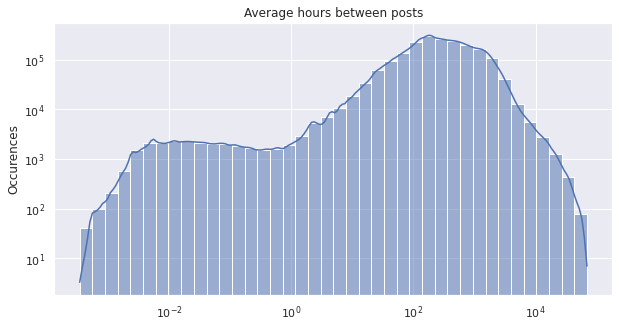

In [104]:
posters = posters[posters.drift > pd.Timedelta(seconds=1)]
ax = sns.histplot(
    x=posters.drift.dt.total_seconds()/3600,
    log_scale=True,
    bins=40,
    kde=True, 
    palette='pastel')
ax.set(
    title='Average hours between posts per user',
    xlabel='',
    yscale='log',
    ylabel='Occurences'
)
plt.show()

We note that there are some users that tend to post very very often, as in fact we note a small bump when the x-axis is around $10^{-2} hours \sim 36s$. This denotes all those profiles that tend to post at an unhuman frequency, and may indicate errors in the dataset or that the profile is operated by a bot.

And now, the requested Mondrian painting:

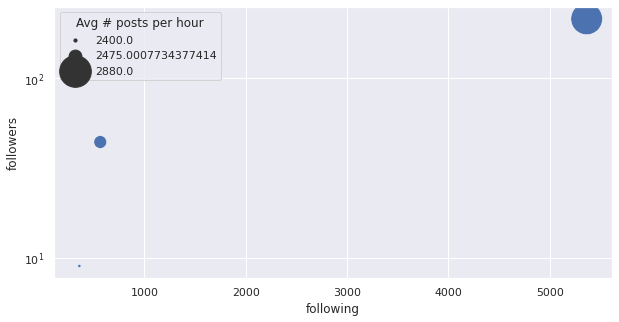

In [109]:
top3 = posters.nsmallest(3, columns='drift')
ax = sns.scatterplot(data=top3,
                x="following", 
                y="followers", 
                size=3600/top3['drift'].dt.total_seconds(), 
                sizes=(10,1000),
                palette="pastel")
ax.legend(title='Avg # posts per hour')
ax.set_yscale('log')
plt.show()

KeyboardInterrupt: 

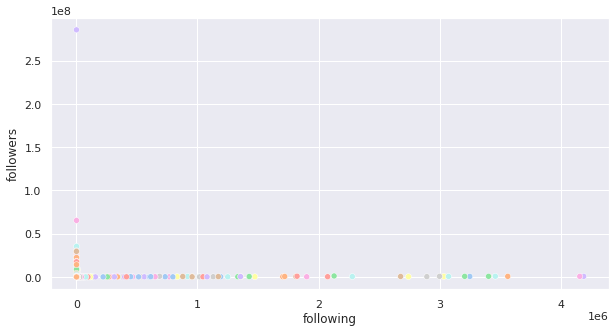

In [108]:
ax = sns.scatterplot(data=posters,
                x="following", 
                y="followers", 
                hue=3600/posters['drift'].dt.total_seconds(), 
                hue_norm = (0,1),
                palette="pastel")
ax.legend(title='Avg # posts per hour')
ax.set(
    yscale='log',
    xscale='log'
)
plt.show()

In [ ]:
ax = sns.kdeplot(data=posters,
                x="count" ,
                y=3600/posters.drift.dt.total_seconds(), 
                palette="pastel")
ax.set(
    title="Correlation between number of posts and frequency",
    yscale='log',
#     xscale='log'
)
plt.show()

In [ ]:
del drift 
del post_time

#### Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

In [134]:
likes_time = posts.col(['numbr_likes', 'number_comments', 'cts'], index=False)
likes_time['hour'] = likes_time['cts'].dt.hour
likes_time.drop('cts', inplace=True, axis=1)

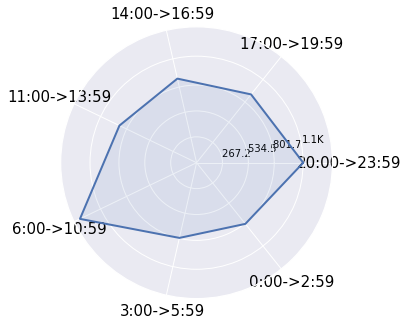

In [135]:
plot_intervals(likes_time.groupby(by='hour').agg('mean'), INTERVALS, col_name='numbr_likes')

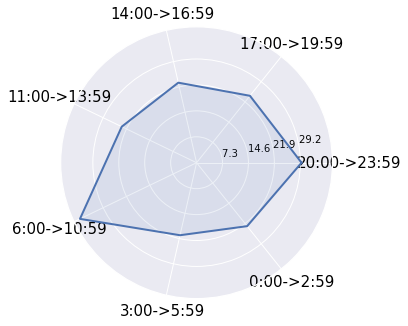

In [136]:
plot_intervals(likes_time.groupby(by='hour').agg('mean'), INTERVALS, col_name='number_comments')

In [ ]:
del likes_time

#### 7. __[RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let's compute some engaging figures__

#### $\bullet$ What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

#### $\bullet$ Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

### 8. __[RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check whether a hypothesis is correct or not.__

#### $\bullet$ Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

#### $\bullet$ Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

#### $\bullet$ What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

#### $\bullet$ What are histograms, bar plots, scatterplots and pie charts used for?

#### $\bullet$ What insights can you extract from a Box Plot?

***

## __Bonus points__

***

#### Up to this point, you probably have worked with one or two files simultaneously. Nevertheless, for the literals a. and b. of this section, you must work with the three datasets at the same time. Note that performing some of these operations might be too complex for your pc specs. For this reason, we suggest you make use of AWS (yeah! only a suggestion). In case you need it, in the following links you can find the same three files already mounted into AWS for you to work with them easily (instagram_posts, instagram_profiles, instagram_locations).

#### a. Sort the users in terms of number of followers and divide them into two groups: for the first group, take only the top 10% regarding "followers", and for the second one, take the rest. Now compare the mean of time intervals between posts for the two categories. Do you notice something relevant?

In [9]:
profiles.df = profiles.col(['followers'], index=True).dropna()
profiles.df.head()

,followers
sid,
4184446,146
4184457,1145
4184460,324
4184465,192
4184471,4137


In [44]:
drift = lambda g: (g.max() - g.min()) / (g.count()-1) if g.shape[0] > 1 else pd.NA

post_time = posts\
                .col(['sid_profile','cts'], index=None)\
                .groupby(by=['sid_profile'], sort=False, dropna=True)\
                .agg(drift=pd.NamedAgg(column="cts", aggfunc=drift))\
                .dropna()
post_time = post_time[post_time.index.get_level_values('sid_profile') != -1]
post_time['drift'] = post_time['drift'].astype('timedelta64[ns]')
post_time.head()

,drift
sid_profile,
3496776,17 days 10:03:56.027027
3303402,79 days 09:58:46.133333
3406435,2 days 02:45:14.545454
3529017,3 days 18:16:18.687500
3206132,124 days 00:16:34.333333


In [45]:
profiles.df = pd.concat([
    post_time,
    profiles.df[['followers']]
], axis=1, join='inner')
profiles.df.head()

,drift,followers
1817101,5 days 14:09:50.187500,858
3521482,20 days 12:59:05.047619,5099
1891211,80 days 13:46:52.250000,559
4293767,22 days 22:59:48.409090,926
3414742,125 days 21:28:32.812500,4161


In [46]:
profiles.df['category'] = pd.qcut(profiles.df.followers, [0.,0.9,1.], labels=['norm', 'influencer'])

print('Influencers mean time between posts: \t', profiles.df[profiles.df.category=='influencer'].drift.mean())
print('Normal users mean time between posts: \t', profiles.df[profiles.df.category=='norm'].drift.mean())

Influencers mean time between posts: 	 10 days 14:46:14.786765333

Normal users mean time between posts: 	 23 days 09:13:00.539863666


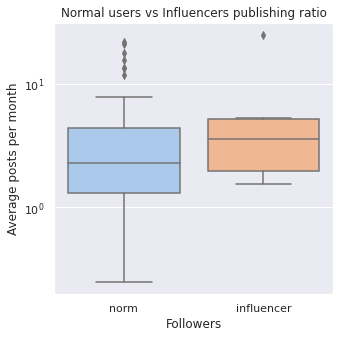

In [47]:
sns.set(rc={'figure.figsize':(5,5)})

ax = sns.boxplot(data=profiles.df, 
            x='category', 
            y=24*31*3600/profiles.df['drift'].dt.total_seconds(), 
            palette='pastel')
ax.set(
    xlabel = 'Followers',
    ylabel = 'Average posts per month',
    title = 'Normal users vs Influencers publishing ratio',
    yscale = 'log')
plt.show()

In [48]:
del post_time
del profiles.df

#### b. Assume users publish their posts the same day pictures or videos are taken: Are there users that have visited the same location on the same day? How about the same week? Extract the results and explain them.

In [49]:
posts.df = posts\
    .col(['location_id', 'profile_id', 'cts'])\
    .dropna()

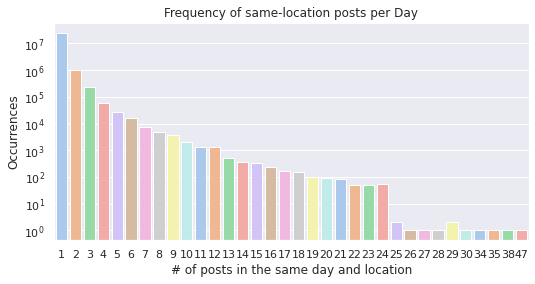

In [50]:
day = posts.df\
            .groupby([pd.Grouper(key="cts", freq="1d"), 'location_id', 'profile_id'], sort=False)\
            .agg(cnt=pd.NamedAgg(column="cts", aggfunc='count'))['cnt']\
            .value_counts().sort_index()
sns.set(rc={'figure.figsize':(day.index.shape[0]/4,4)})
ax = sns.barplot(x=day.index, y=day, palette='pastel')
ax.set(
    xlabel = '# of posts in the same day and location',
    ylabel = 'Occurrences',
    title = 'Frequency of same-location posts per Day',
    yscale = 'log'
)
plt.show()

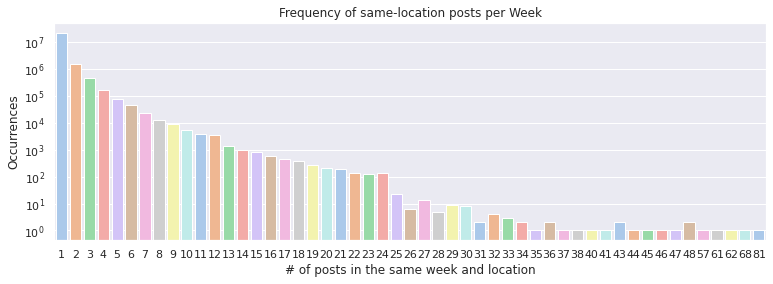

In [51]:
week = posts.df\
            .groupby([pd.Grouper(key="cts", freq="1W"), 'location_id', 'profile_id'], sort=False)\
            .agg(cnt=pd.NamedAgg(column="cts", aggfunc='count'))['cnt']\
            .value_counts().sort_index()
sns.set(rc={'figure.figsize':(week.index.shape[0]/4,4)})
ax = sns.barplot(x=week.index, y=week, palette='pastel')
ax.set(
    xlabel = '# of posts in the same week and location',
    ylabel = 'Occurrences',
    title = 'Frequency of same-location posts per Week',
    yscale = 'log'
)
plt.show()

In [52]:
del posts.df

#### c. Implement a text data analysis (also known as text mining) of the field "description" from instagram_posts.csv for descriptions written in English. Use appropriate visualizations and statistics to highlight the words (and probably the topics) provided for the users in that field.

The `langdetect` package uses a pretrained machine learning algorithm that supports 55 languages. Given any string it returns the closest match (if possible).

In [51]:
%pip install langdetect
from langdetect import detect

detect('Ciao Matteo come stai?')

Note: you may need to restart the kernel to use updated packages.


'it'

Some of the strings may be too short for recognition, so we discard them. Also some strings may be composed of emojis only or mostly and those will give an error when passed to the `detect` function, so we enclose it in a `try-catch` statement.

In [19]:
descr = posts.col(['description'], index=False, max_nrows=10000).dropna()
descr = descr[descr.description.str.len() > 8]
# Remove emojis and newlines

def safe_detect(s):
    try:
        return detect(s)
    except:
        return pd.NA
        
        
descr['lang'] = descr.description.apply(safe_detect).dropna()

🎶🎶🎶☮☮✌✌✌✌✌✌😘😘👌👌
💕😚 𝒮𝒾𝓂𝓅𝓁𝓎 𝒮𝒾𝓂𝓅𝓁𝑒 😚💕
🌊25.05.2019
𝑀𝓎 18𝓉𝒽 𝐵𝒾𝓇𝓉𝒽𝒹𝒶𝓎💐
❤️💝💞💛❣️💛💓💚❤️🖤💞🧡❣️💕🧡💘💚💗💙💖💛💓🧡💞💕🤩🖤💓❤️❣️💞❣️💚🧡🖤💞💓💛💞💝
💋\n@feehsantana3
❄️🌲🌍🌪🧥⛄️🧣😎🌨🧤🌬🏂
— 𝙉𝙚 𝙢𝙚𝙘𝙝𝙩𝙖𝙞, 𝙖 𝙗𝙪𝙙’ 𝙢𝙚𝙘𝙝𝙩𝙤𝙞🌹
𝓉𝒽𝑒 𝓅𝒽𝑜𝓃𝑒 𝒽𝒶𝓈 𝓇𝒾𝓃𝑔𝒾𝓃𝑔☎️
.\n⠀ ⠀ 🚖💰🚖🙃
😏\n@anikeevision
ᵞᴼᵁ ᴷᴺᴼᵂ ᵂᴴᴬᵀ, ᴵ ᶠᴱᴱᴸ ˢᴼ ᴾᴿᴼᵁᴰ ᵀᴼ ᴴᴬᵛᴱ ᴬ ᴮᴿᴼᵀᴴᴱᴿ ᴸᴵᴷᴱ ᵞᴼᵁ. ᵞᴼᵁ ᴬᴿᴱ ᴹᵞ ᴮᴱˢᵀ ᶠᴿᴵᴱᴺᴰ. ᴼᴺ ᵀᴴᴵˢ ˢᴾᴱᶜᴵᴬᴸ ᴰᴬᵞ, ᴵ ᵂᴬᴺᵀ ᵀᴼ ˢᴬᵞ ᵞᴼᵁ, ᴴᴬᴾᴾᵞ ᴮᴵᴿᵀᴴᴰᴬᵞ ᴮᴿᴼᵀᴴᴱᴿ #happybirthday


Most common languages:

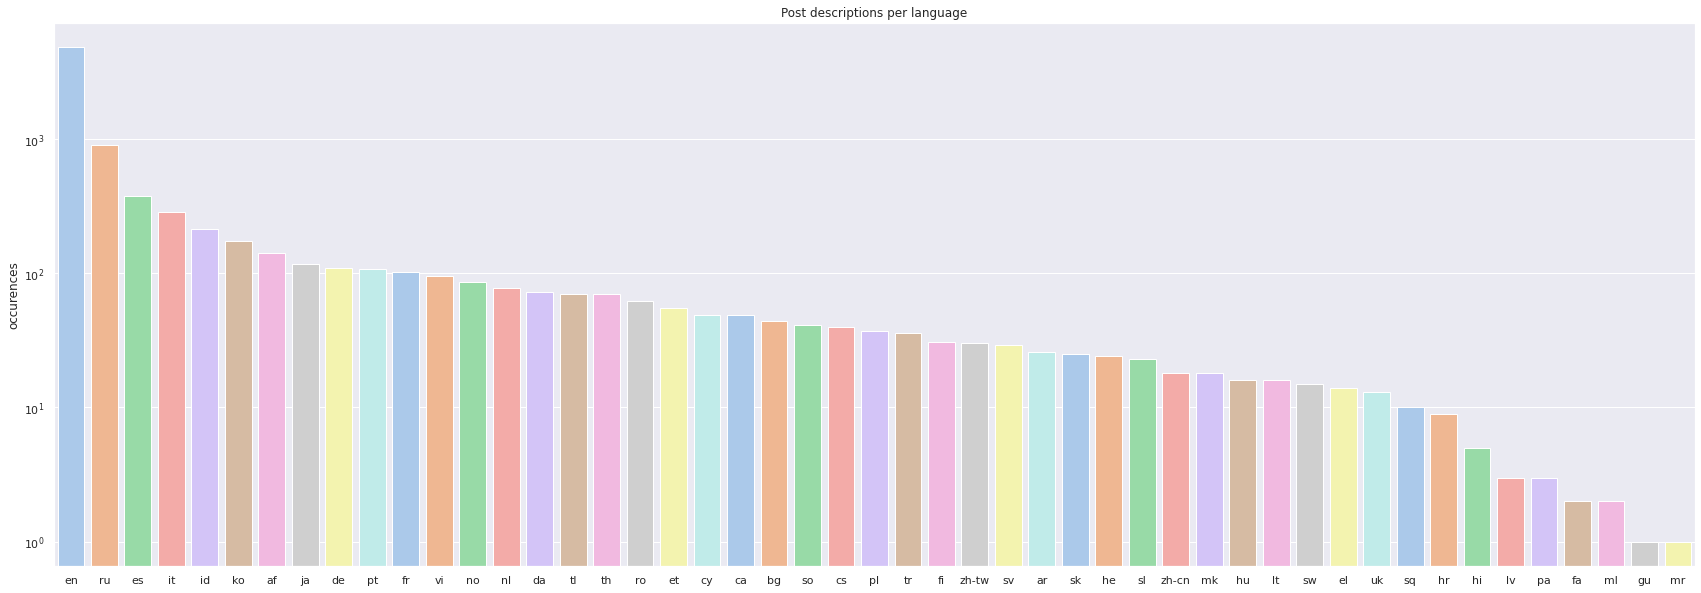

In [65]:
lang_share = descr.lang.value_counts()
g = sns.barplot(
    x=lang_share.index,
    y=lang_share,
    palette='pastel')
sns.set(rc={'figure.figsize':(.6*lang_share.count(),5)})
g.set(
    title='Post descriptions per language',
    yscale='log',
    ylabel='occurences'
)
plt.show()

`WordCloud` is a graphic library that helps you plot the most prominent words in a text to a Tag Cloud graph. After filtering out some of the words as Stopwords and selecting only the columns in english language, we are able to plot the most used words in english descriptions. 

In [53]:
from wordcloud import WordCloud, STOPWORDS
import string
STOPWORDS = set(STOPWORDS)
STOPWORDS.update({c for c in string.printable})

english_descr = descr.description[descr.lang == 'en']

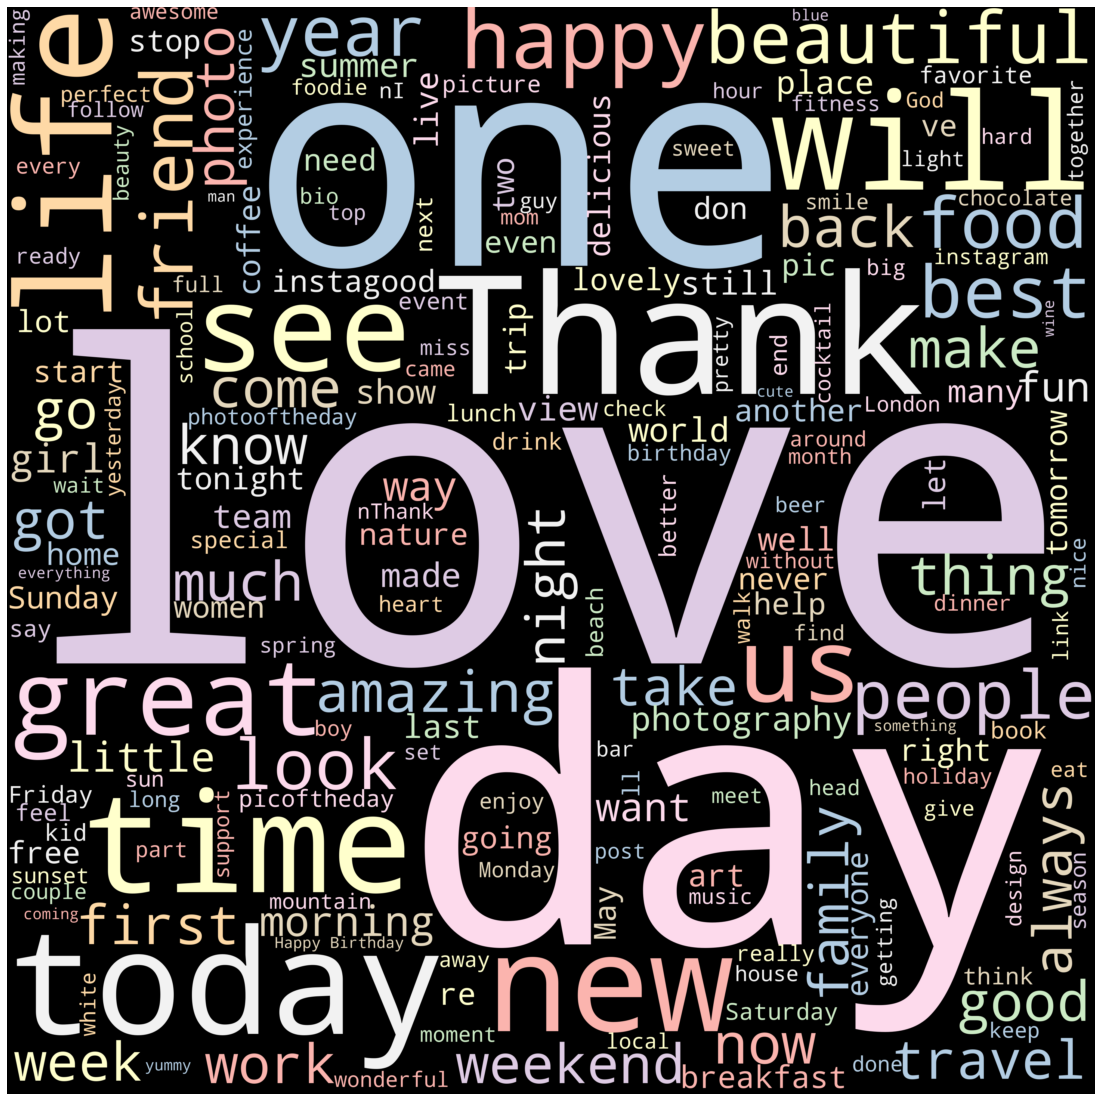

In [60]:
wordcloud = WordCloud(
    width=2000, 
    height=2000, 
    margin=0, 
    stopwords=STOPWORDS, 
    background_color='black', 
    colormap='Pastel1',
    scale=2
).generate(" ".join(english_descr))

plt.figure( figsize=(20,20) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In order to analyze the results I would split it in some groups:
- Day : `day, today, now` : Many words refer to the current day meaning that this descriptions might have been used to refer and talk about the present events. This might point to a usage of descriptions (and Instagram) to talk and express feelings, as a way to interact with the world.
- Positives : `love, friend, thank, happy, life, beautiful` : There are many words that refer to the 'positive-thinking' sphere, meaning that users tend to post mainly positive things about themselves and their surroundings. This may confirm the known trend of the users being biased, trying to show out mainly positive things about them and their life.

In [ ]:
del descr
del english_descr


***

## __Command Line Question__

***

#### Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also does not use as much CPU processing time as other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

#### In this question, you should use command line tools such as grep and possibly other commands to answer the following question:

#### $\bullet$ Using the instagram_posts.csv, retrieve the first ten posts with descriptions longer than 100 characters and output the profiles that posted them. (Please keep in mind that the profile associated with some of those posts may not be found in the profiles. You can simply output User was not found! for those posts.)

#### Note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

***

## __Algorithmic Question__

***

### 1. __[AQ1] Given the following pseudocode, answer the questions:__

'''
Input:
       N : an integer
       List : array of characters of leng
   function f1(sequence, end):
       For i=0 To end:
           OUTPUT sequence[i]
       EndFor
Output "\n"
   function f2(sequence, start, end):
       If start = end:
           f1(sequence, end)
       Else
           For i=start To end:
               temp <-- sequence[start]
               sequence[start] <-- sequen
               sequence[i] <-- temp
               f2(sequence, start+1, end)
               temp <-- sequence[start]
               sequence[start] <-- sequen
               sequence[i] <-- temp
   f2(List, 0, N)
'''

#### $\bullet$ What is the output of this algorithm? Describe the mechanism of the algorithm in detail . We do not want to know only its final result. (Describe one example on your own)

#### $\bullet$ What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?

#### $\bullet$ Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?

### 3. __[AQ2] Considering the following problem, answer the questions:__

#### Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following __three__ conditions:
- Each piece of the cut should have an integer length
- He should at least cut the ribbon once
- The __multiplication__ of the length of all the pieces be the maximum possible

#### 1. Implement a __recursive algorithm__ to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.

In [ ]:
def ribbon_cut_exp(N):
    if N <= 2:
        return 1
    l = [N]
    for i in range(1,N//2+1):
        l.append(max(i, ribbon_cut_exp(i)) * max(N-i, ribbon_cut_exp(N-i)))
    return max(l)
                            
ribbon_cut_exp(27)

#### 2. Show that the algorithm has exponential running time.

When the function is called with a certain parameter $N$ the func calls $N-1$ other instances of itself with parameters $\{n | n \in (1,N-1)\}$. Each function has $O(n)$ complexity, since it finds the maximum in an array of length $n/2$.

So the number of executions is
$$
    (N-2) + 2^1(N-3) + 2^2(N-4) + 2^3(N-5) + ... + 2^N 1 = O(2^N) 
$$

#### 3. Now provide a polynomial solution, based on __dynamic programming__, and compute its running-time complexity.

In [ ]:
def ribbon_cut_poly(N):
    if N <= 2:
        return 1
    cuts = [1,2]
    for x in range(3,N+1):
        l = [x]
        for i in range(1,x//2+1):
            l.append(max(i, cuts[i-1]) * max(x-i, cuts[x-i-1]))
        cuts.append(max(l))
    # print(cuts)
    return cuts[N-1]
    
ribbon_cut_poly(12)

At the $j^{th}$ iteration of the outer loop, it iterates $j/2$ times in the inner loop. The inner loop computes some $O(1)$ operations and then appends at the result at a list ($O(1)$). At the end a search for the maximum is performed on an array of length $j/2$, complexity of this last operation is $O(j/2)$.
At the end the total number of operations performed is:
$$
    1 + 2 + ... + (N-1) + N = \frac{N (N-1)}{2} = O(N^2)
$$

#### 4. Evaluate the running time of your algorithm for the sizes (Ns) in the __range of [2, 25]__, plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

In [ ]:
from timeit import timeit

performance = {
    'time' : [],
    'type' : [],
    'N' : []
}
N_RANGE = 26
for i in range(2,N_RANGE):
    print(f"{i}th iteration")
    performance['time'].append(timeit(lambda: ribbon_cut_poly(i), number = 10000) * 10**3)
    performance['type'].append('poly')
    performance['N'].append(i)
    
    performance['N'].append(i)
    performance['time'].append(timeit(lambda: ribbon_cut_exp(i), number=1000) * 10**3)
    performance['type'].append('exp')

In [ ]:
cut_performance = pd.DataFrame.from_dict(performance)
sns.lineplot(data=cut_performance,x='N', y='time', hue='type', palette='pastel')

#### 5. (Optional, mini bonus) Is the algorithm of question 3 __optimal__? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

The algorithm is not optimal, because the answer can be easily computed by a constant function with complexity $O(1)$

$
f(x) = 
\begin{cases} 
          x & 0 < x \leq 2 \\
          3^{\frac{x}{3}} & x \mod{3} = 0 \\
          2^2 \cdot 3^{\frac{(x-4)}{3}} & x \mod{3} = 1\\
          2 \cdot 3^{\frac{x-2}{3}} & x \mod{3} = 2
       \end{cases}
$

In [ ]:
def ribbon_cut_const(N):
    if N <= 3:
        return N
    if N % 3 == 0:
        return 3** (N // 3)
    if N % 3 == 1:
        return 4 * 3** ((N-4)//3)
    if N % 3 == 2:
        return 3**(N//3) * 2
    
ribbon_cut_const(26)

In [ ]:
for i in range(1,N_RANGE):
    performance['N'].append(i)
    performance['time'].append(timeit(lambda: ribbon_cut_const(i), number=1000) * 10**3)
    performance['type'].append('const')
    
cut_performance = pd.DataFrame.from_dict(performance)
sns.lineplot(data=cut_performance,x='N', y='time', hue='type', palette='pastel')